<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Experiments/Transformer/TimeSeries/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from pathlib import Path
from sklearn import model_selection

def generate_data(data_path, num_steps, interval=0.1):
    np.random.seed(seed=42)
    x = np.linspace(start=0, stop=num_steps * interval, num=num_steps)
    y = np.sin(x) + np.random.normal(loc=0, scale=0.1, size=x.shape)
    np.savez(file=data_path, y=y)

data_path = 'data.npz'
generate_data(data_path=data_path, num_steps=1000000)

def load_and_partition_data(data_path, seq_length=100):

    data = np.load(data_path)
    num_features = len(data.keys())

    data_lens = [len(data[key]) for key in data.keys()]
    assert len(set(data_lens)) == 1

    num_sequences = data_lens[0] // seq_length
    sequences = np.empty(shape=(num_sequences, seq_length, num_features))

    for i in range(0, num_sequences):
        sample = np.asarray(a=[data[key][i * seq_length : (i + 1) * seq_length]
            for key in data.keys()]
        ).swapaxes(0, 1)
        sequences[i] = sample
    return sequences, num_features

sequences, num_features = load_and_partition_data('data.npz')
seq_train, seq_test = model_selection.train_test_split(sequences, test_size=0.2,
    random_state=42)

seq_train.shape

(8000, 100, 1)

In [ ]:
import numpy as np
import torch

class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, seqs, ratio=0.8):
        super().__init__()
        self.seqs = seqs
        self.ratio = ratio

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        src_end = int(seq.shape[0] * self.ratio)
        src = torch.tensor(data=seq[:src_end], dtype=torch.float32)
        tgt = torch.tensor(data=seq[src_end - 1 : -1], dtype=torch.float32)
        tgt_y = torch.tensor(data=seq[src_end:], dtype=torch.float32)
        return src, tgt, tgt_y

dl_train = torch.utils.data.DataLoader(dataset=SeqDataset(seqs=seq_train),
    batch_size=512, shuffle=True)
dl_test = torch.utils.data.DataLoader(dataset=SeqDataset(seqs=seq_test),
    batch_size=512, shuffle=False)
len(dl_train), len(dl_test)

(16, 4)

In [ ]:
import torch
import numpy as np

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        position = torch.arange(end=max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float()
            * (-np.log(10000.0) / d_model))
        pe = torch.zeros(size=(1, max_len, d_model))
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerWithPE(torch.nn.Module):
    def __init__(self, in_dim, out_dim, d_model, nhead, num_layers):
        super().__init__()
        self.encoder_embedding = torch.nn.Linear(in_features=in_dim,
            out_features=d_model)
        self.decoder_embedding = torch.nn.Linear(in_features=out_dim,
            out_features=d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model)

        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
            num_encoder_layers=num_layers, num_decoder_layers=num_layers,
            batch_first=True)

        self.output_layer = torch.nn.Linear(in_features=d_model,
            out_features=out_dim)

    def forward(self, src, tgt):
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(
            sz=tgt.shape[1])

        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        pred = self.transformer(src=src, tgt=tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)
        return pred

    def infer(self, src, tgt_len):
        output = torch.zeros(size=(src.shape[0], tgt_len + 1, src.shape[2]))\
            .to(src.device)
        output[:, 0] = src[:, -1]
        for i in range(tgt_len):
            output[:, i + 1] = model.forward(src=src, tgt=output)[:, i]
        return output[:, 1:]

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerWithPE(in_dim=num_features, out_dim=num_features,
    d_model=128, nhead=8, num_layers=2
).to(device)

Training duration: 399.25s


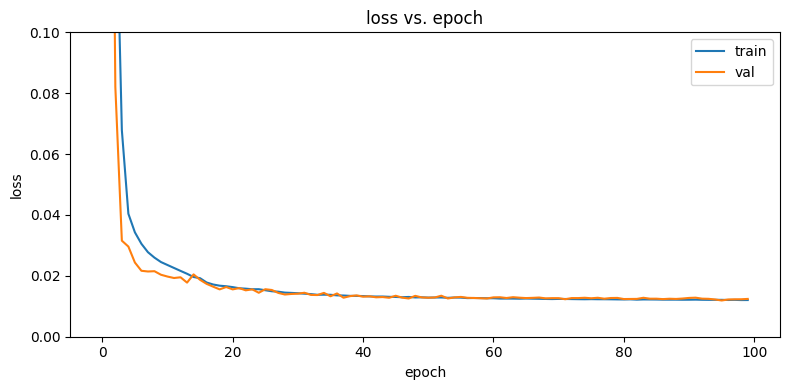

In [ ]:
import numpy as np
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_step(model, dl, criterion, optimizer):
    model.train()
    losses = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for src, tgt, tgt_y in dl:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model(src=src, tgt=tgt)
        loss = criterion(input=y_pred, target=tgt_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test_step(model, dl, criterion):
    model.eval()
    losses = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for src, tgt, tgt_y in dl:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model(src=src, tgt=tgt)
        loss = criterion(input=y_pred, target=tgt_y)
        losses.append(loss.item())
    return np.mean(losses)

def train_model(model, dl_train, dl_val, epochs):
    torch.manual_seed(seed=42)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
        mode='min', factor=0.9, patience=3)

    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        train_loss = train_step(model=model, dl=dl_train, criterion=criterion,
            optimizer=optimizer)
        history['train_loss'].append(train_loss)
        val_loss = test_step(model=model, dl=dl_val, criterion=criterion)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)
    return model, history

start_time = time.time()
model, history = train_model(model=model, dl_train=dl_train, dl_val=dl_test,
    epochs=100)
print(f"Training duration: %.2fs"%(time.time() - start_time))

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='val_loss', label='val')
    plt.legend(loc='best')
    plt.title(label=f'loss vs. epoch')
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss')
    plt.ylim(bottom=0, top=0.1)
    plt.tight_layout()
    plt.show()

plot_history(history=history)

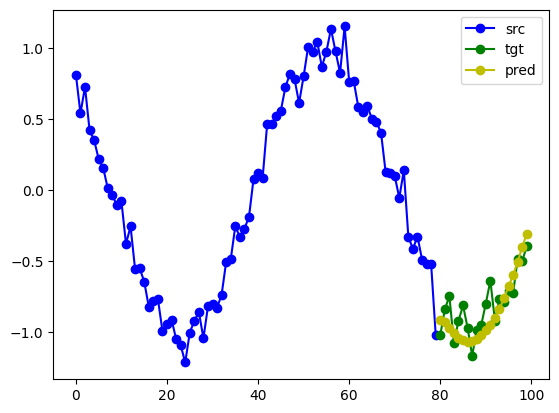

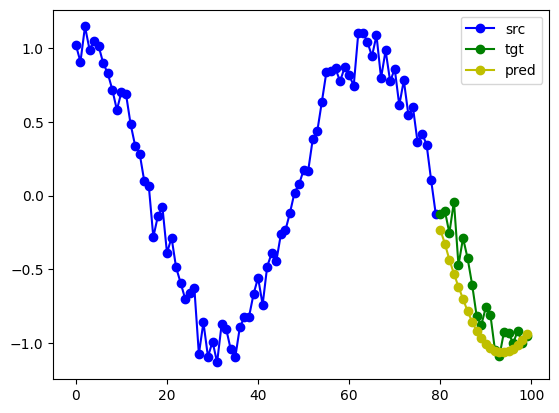

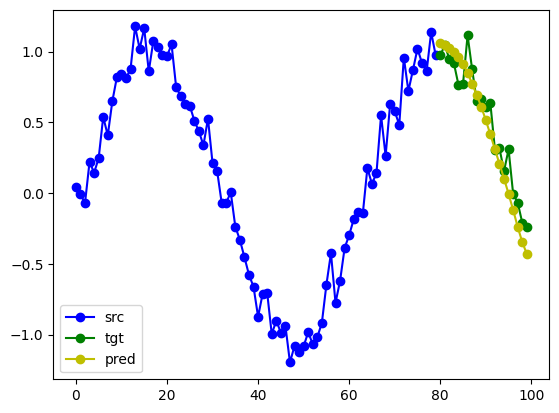

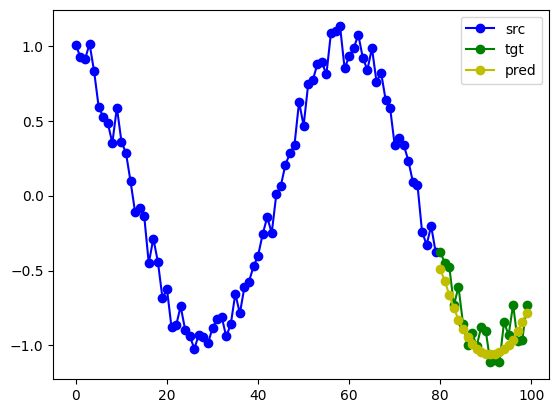

<Figure size 640x480 with 0 Axes>

In [ ]:
model.eval()
with torch.no_grad():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for src, tgt, tgt_y in dl_test:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model.infer(src=src, tgt_len=tgt.shape[1])

        x = np.arange(src.shape[1] + tgt.shape[1])
        src_len = src.shape[1]
        idx = 0
        plt.plot(x[:src_len], src[idx].cpu().detach(), "bo-", label="src")
        plt.plot(x[src_len:], tgt[idx].cpu().detach(), "go-", label="tgt")
        plt.plot(x[src_len:], y_pred[idx].cpu().detach(), "yo-", label="pred")

        plt.legend()
        plt.show()
        plt.clf()

In [2]:
import pandas as pd

csv_file = 'https://raw.githubusercontent.com/KasperGroesLudvigsen/influenza_transformer/refs/heads/main/data/dfs_merged_upload.csv'

df_raw = pd.read_csv(csv_file, index_col=0, parse_dates=['timestamp'])
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45985 entries, 0 to 45984
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   timestamp       45985 non-null  datetime64[ns, UTC]
 1   FCR_N_PriceEUR  45985 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 1.1 MB


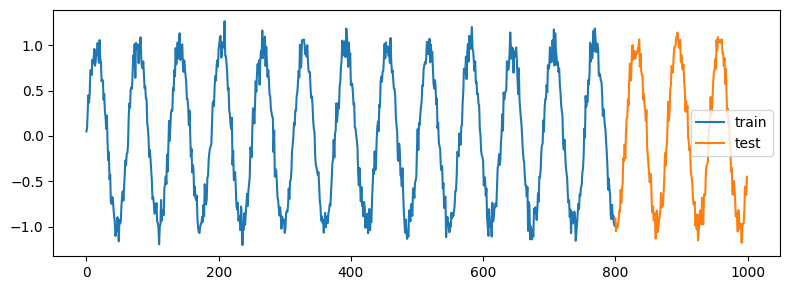

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_ts(num_steps, interval=0.1):
    np.random.seed(seed=42)
    t = np.linspace(start=0, stop=num_steps * interval, num=num_steps)
    data = np.sin(t) + np.random.normal(loc=0, scale=0.1, size=t.shape)
    return data

ts = generate_ts(num_steps=1000)
ts_train, ts_test = ts[:-int(len(ts)*.2)], ts[-int(len(ts)*.2):]

plt.figure(figsize=(8, 3))
plt.plot(range(0, len(ts_train)), ts_train, label='train')
plt.plot(range(len(ts_train), len(ts)), ts_test, label='test')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch

def create_seqs(ts, in_window=24, out_window=12):
    seqs = []
    for i in range(len(ts) - (in_window + out_window) + 1):
        src = ts[i : i + in_window]
        tgt = ts[i + in_window -1 : i + in_window + out_window -1]
        tgt_y = ts[i + in_window : i + in_window + out_window]
        seqs.append((src, tgt, tgt_y))
    return seqs

seqs_train = create_seqs(ts=ts_train)
seqs_test = create_seqs(ts=ts_test)

class SeqsDataset(torch.utils.data.Dataset):
    def __init__(self, seqs):
        super().__init__()
        self.seqs = seqs

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        src, tgt, tgt_y = self.seqs[idx]
        src = torch.tensor(data=src, dtype=torch.float32).view(-1, 1)
        tgt = torch.tensor(data=tgt, dtype=torch.float32).view(-1, 1)
        tgt_y = torch.tensor(data=tgt_y, dtype=torch.float32).view(-1, 1)
        return src, tgt, tgt_y

dl_train = torch.utils.data.DataLoader(dataset=SeqsDataset(seqs=seqs_train),
    batch_size=32, shuffle=True)
dl_test = torch.utils.data.DataLoader(dataset=SeqsDataset(seqs=seqs_test),
    batch_size=32, shuffle=False)
len(dl_train), len(dl_test)

(24, 6)

In [ ]:
import torch
import numpy as np

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        position = torch.arange(end=max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float()
            * (-np.log(10000.0) / d_model))
        pe = torch.zeros(size=(1, max_len, d_model))
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerWithPE(torch.nn.Module):
    def __init__(self, in_dim, out_dim, d_model, nhead, num_layers):
        super().__init__()
        self.encoder_embedding = torch.nn.Linear(in_features=in_dim,
            out_features=d_model)
        self.decoder_embedding = torch.nn.Linear(in_features=out_dim,
            out_features=d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model)

        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
            num_encoder_layers=num_layers, num_decoder_layers=num_layers,
            batch_first=True)

        self.output_layer = torch.nn.Linear(in_features=d_model,
            out_features=out_dim)

    def forward(self, src, tgt):
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(
            sz=tgt.shape[1])

        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        pred = self.transformer(src=src, tgt=tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)
        return pred

    def infer(self, src, tgt_len):
        output = torch.zeros(size=(src.shape[0], tgt_len + 1, src.shape[2]))\
            .to(src.device)
        output[:, 0] = src[:, -1]
        for i in range(tgt_len):
            output[:, i + 1] = model.forward(src=src, tgt=output)[:, i]
        return output[:, 1:]

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerWithPE(in_dim=1, out_dim=1,
    d_model=128, nhead=8, num_layers=2
).to(device)

Training duration: 778.44s


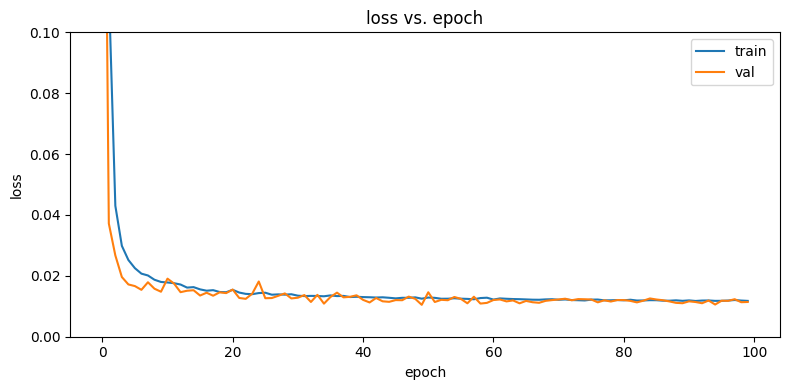

In [ ]:
import numpy as np
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_step(model, dl, criterion, optimizer):
    model.train()
    losses = []
    for src, tgt, tgt_y in dl:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model(src=src, tgt=tgt)
        loss = criterion(input=y_pred, target=tgt_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test_step(model, dl, criterion):
    model.eval()
    losses = []
    for src, tgt, tgt_y in dl:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model(src=src, tgt=tgt)
        loss = criterion(input=y_pred, target=tgt_y)
        losses.append(loss.item())
    return np.mean(losses)

def train_model(model, dl_train, dl_val, epochs):
    torch.manual_seed(seed=42)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
        mode='min', factor=0.9, patience=3)

    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        train_loss = train_step(model=model, dl=dl_train, criterion=criterion,
            optimizer=optimizer)
        history['train_loss'].append(train_loss)
        val_loss = test_step(model=model, dl=dl_val, criterion=criterion)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)
    return model, history

start_time = time.time()
model, history = train_model(model=model, dl_train=dl_train, dl_val=dl_test,
    epochs=100)
print(f"Training duration: %.2fs"%(time.time() - start_time))

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='val_loss', label='val')
    plt.legend(loc='best')
    plt.title(label=f'loss vs. epoch')
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss')
    plt.ylim(bottom=0, top=0.1)
    plt.tight_layout()
    plt.show()

plot_history(history=history)

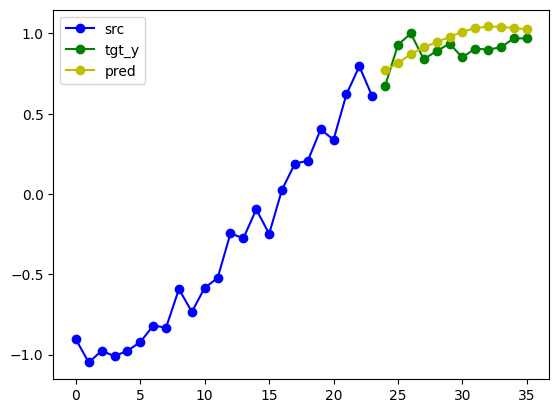

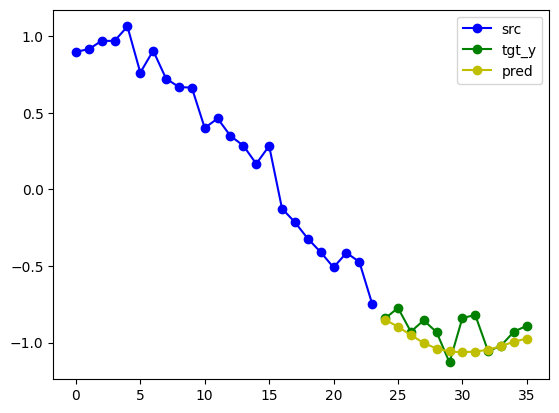

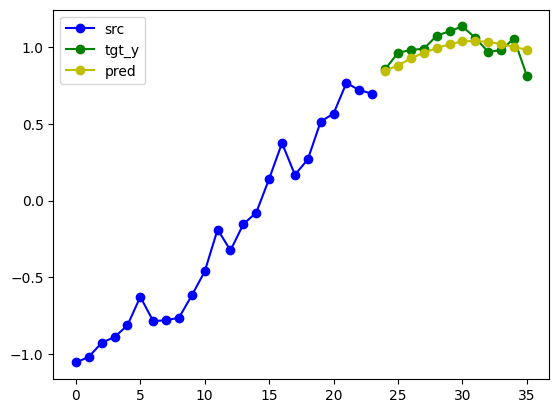

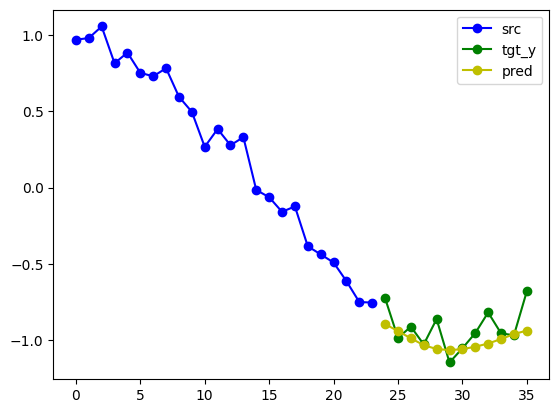

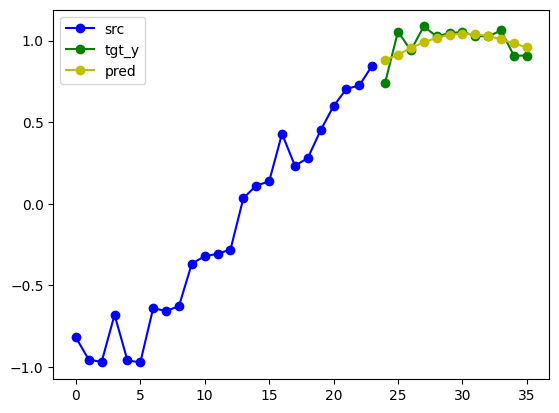

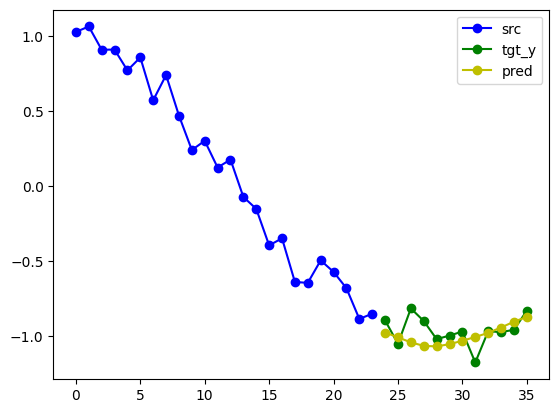

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for src, tgt, tgt_y in dl_test:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model.infer(src=src, tgt_len=tgt_y.shape[1])

        x = np.arange(src.shape[1] + tgt_y.shape[1])
        src_len = src.shape[1]
        idx = 0
        plt.plot(x[:src_len], src[idx].cpu().detach(), "bo-", label="src")
        plt.plot(x[src_len:], tgt_y[idx].cpu().detach(), "go-", label="tgt_y")
        plt.plot(x[src_len:], y_pred[idx].cpu().detach(), "yo-", label="pred")

        plt.legend()
        plt.show()
        plt.clf()

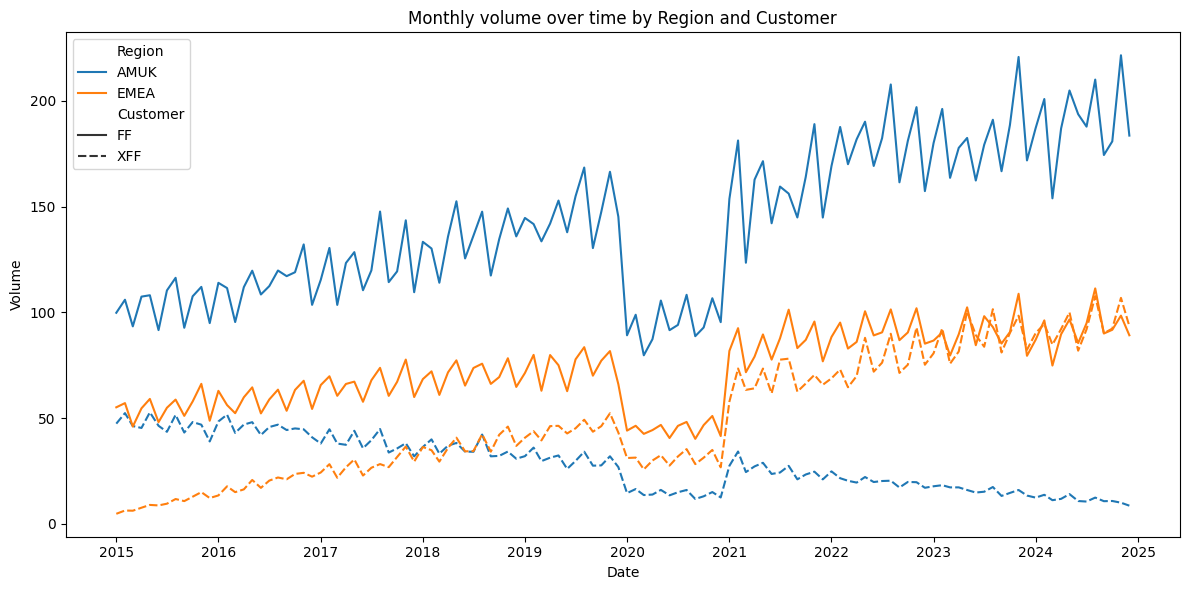

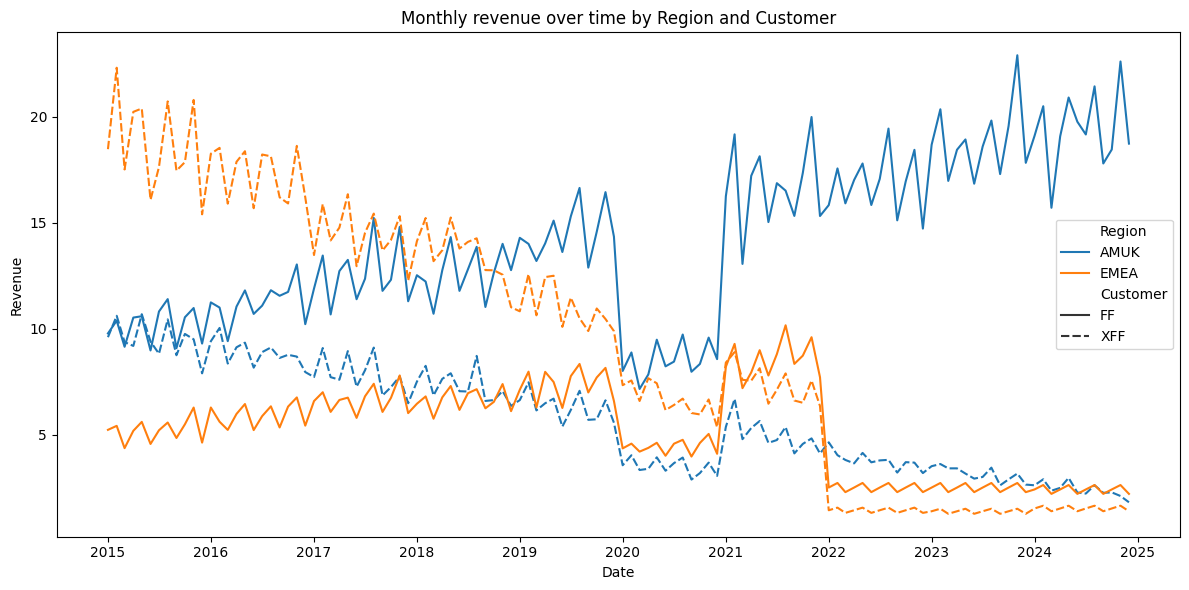

In [ ]:
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

regions = ['AMUK', 'EMEA']
customers = ['FF', 'XFF']
features = ['Volume', 'Revenue']

start_date = '2015-01-01'
years = 10
periods = years * 12
time_index = pd.date_range(start=start_date, periods=periods, freq='MS')

def quarterly_seasonality(length, amplitude=0.1):
    t = np.arange(length)
    return 1 + amplitude * np.sin(2 * np.pi * t/3)

def generate_trend(start, end, length, noise=0.05):
    base = np.linspace(start=start, stop=end, num=length)
    return base * (1 + noise * np.random.randn(length))

def flatten_after(date_index, data, flatten_date, flat_level=None):
    flat_start = pd.Timestamp(flatten_date)
    mask = date_index >= flat_start
    if flat_level is None:
        flat_level = data[data_index==flat_start][0] \
            if (date_index==flat_start).any() else data[-1]
    data[mask] = flat_level
    return data

def apply_yearly_shocks(date_index, data):
    data = data.copy()
    years = sorted(set(date_index.year))
    for yr in years:
        mask = date_index.year==yr
        if yr==2020:
            shock = np.random.uniform(low=-0.5, high=-0.3)
        else:
            shock = np.random.uniform(low=-0.05, high=0.05)
        data[mask] *= (1 + shock)
    return data

records = []

for region in regions:
    for customer in customers:
        seasonal = quarterly_seasonality(length=periods)

        if region=='AMUK' and customer=='FF':
            volume = generate_trend(start=100, end=200, length=periods)
            revenue = 0.1 * volume

        elif region=='AMUK' and customer=='XFF':
            volume = generate_trend(start=50, end=10, length=periods)
            revenue = 0.2 * volume

        elif region=='EMEA' and customer=='FF':
            volume = generate_trend(start=50, end=100, length=periods)
            revenue = 0.1 * volume
            revenue = flatten_after(date_index=time_index, data=revenue.copy(),
                flatten_date='2022-01-01',
                flat_level=revenue[time_index.get_loc('2021-12-01')]*0.3)

        elif region=='EMEA' and customer=='XFF':
            volume = generate_trend(start=5, end=100, length=periods)
            revenue = 0.2 * generate_trend(start=100, end=5, length=periods)
            revenue = flatten_after(date_index=time_index, data=revenue.copy(),
                flatten_date='2022-01-01',
                flat_level=revenue[time_index.get_loc('2021-12-01')]*0.2)

        volume *= seasonal
        revenue *= seasonal

        volume = apply_yearly_shocks(date_index=time_index, data=volume)
        revenue = apply_yearly_shocks(date_index=time_index, data=revenue)

        for t, v, r in zip(time_index, volume, revenue):
            records.append([t, region, customer, v, r])

df_history = pd.DataFrame(records,
    columns=['Date', 'Region', 'Customer', 'Volume', 'Revenue'])
df_history['Date'] = pd.to_datetime(df_history['Date'])
df_history = df_history.sort_values(by='Date').reset_index(drop=True)
df_history['Month'] = df_history['Date'].dt.month
df_history['Month_sin'] = np.sin(2*np.pi*df_history['Month']/12)
df_history['Month_cos'] = np.cos(2*np.pi*df_history['Month']/12)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_history, x='Date', y='Volume', hue='Region', style='Customer')
plt.title('Monthly volume over time by Region and Customer')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_history, x='Date', y='Revenue', hue='Region', style='Customer')
plt.title('Monthly revenue over time by Region and Customer')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn import preprocessing
import pandas as pd

entities = ['Region', 'Customer']
target_cols = ['Volume', 'Revenue']
time_cols = ['Month_sin', 'Month_cos']
all_input_features = target_cols + time_cols
num_input_features = len(all_input_features)
num_targets = len(target_cols)

regions_unique = sorted(df_history['Region'].unique())
region2idx = {r: i for i, r in enumerate(regions_unique)}

customers_unique = sorted(df_history['Customer'].unique())
customer2idx = {c: i for i, c in enumerate(customers_unique)}

df_scaled = df_history.copy()
scalers = {}
for (region, customer), group in df_history.groupby(by=entities):
    scaler = preprocessing.StandardScaler()
    scaler.fit(X=group[features].values)
    scalers[(region, customer)] = scaler
    df_scaled.loc[group.index, features] = scaler.transform(X=group[features].values)

df_train = df_scaled[df_scaled['Date'] <= '2023-12-01'].copy()
df_test = df_scaled[df_scaled['Date'] >= '2022-01-01'].copy()

print("df_train shape:", df_train.shape)
print("df_test shape:", df_test.shape)

df_train shape: (432, 8)
df_test shape: (144, 8)


In [ ]:
import torch
torch.manual_seed(seed=42)

class TSDataset(torch.utils.data.Dataset):
    def __init__(self, df, in_window=24, out_window=12):
        self.windows = []

        for (region, customer), group in df.groupby(by=entities):
            r_idx = region2idx[region]
            c_idx = customer2idx[customer]
            arr = group.sort_values(by='Date')[all_input_features].values.astype(np.float32)
            max_start = len(arr) - (in_window + out_window) + 1
            if max_start <= 0:
                continue
            for s in range(max_start):
                x = arr[s : s + in_window]
                y = arr[s + in_window : s + in_window + out_window]
                self.windows.append((r_idx, c_idx, x, y))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        r, c, x, y = self.windows[idx]
        return {
            'region': torch.tensor(data=r, dtype=torch.long),
            'customer': torch.tensor(data=c, dtype=torch.long),
            'x': torch.tensor(data=x, dtype=torch.float32),
            'y': torch.tensor(data=y, dtype=torch.float32)
        }

ds_train = TSDataset(df=df_train)
ds_test = TSDataset(df=df_test)

def collate_fn(batch):
    regions = torch.stack(tensors=[b['region'] for b in batch], dim=0)
    customers = torch.stack(tensors=[b['customer'] for b in batch], dim=0)
    x = torch.stack(tensors=[b['x'] for b in batch], dim=0)
    y = torch.stack(tensors=[b['y'] for b in batch], dim=0)
    return regions, customers, x, y

dl_train = torch.utils.data.DataLoader(dataset=ds_train, batch_size=16,
    shuffle=True, collate_fn=collate_fn)
dl_test = torch.utils.data.DataLoader(dataset=ds_test, batch_size=16,
    shuffle=False, collate_fn=collate_fn)

print(f"Train batches: %d, Test batches: %d"%(len(dl_train.dataset),
    len(dl_test.dataset)))

Train batches: 292, Test batches: 4


In [ ]:
import torch
torch.manual_seed(seed=42)

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(size=(max_len, d_model))
        pos = torch.arange(start=0, end=max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(start=0, end=d_model, step=2).float()
            * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :x.size(1), :]

def generate_square_subsequent_mask(sz, device):
    mask = torch.triu(torch.ones(size=(sz, sz), device=device), diagonal=1).bool()
    mask_f = torch.full((sz, sz), float('-inf'), device=device)
    mask_f = mask_f.masked_fill(~mask, 0.0)
    return mask_f

class TransformerSeq2Seq(torch.nn.Module):
    def __init__(self, num_regions, num_customers, num_features,
            d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3,
            dim_feedforward=256, dropout=0.1, entity_emb_dim=8):
        super().__init__()
        self.region_emb = torch.nn.Embedding(num_embeddings=num_regions,
            embedding_dim=entity_emb_dim)
        self.customer_emb = torch.nn.Embedding(num_embeddings=num_customers,
            embedding_dim=entity_emb_dim)
        self.entity_dim = entity_emb_dim * 2

        self.input_proj = torch.nn.Linear(in_features=num_features + self.entity_dim,
            out_features=d_model)
        self.output_proj = torch.nn.Linear(in_features=num_features + self.entity_dim,
            out_features=d_model)
        self.norm_in = torch.nn.LayerNorm(normalized_shape=d_model)
        self.norm_out = torch.nn.LayerNorm(normalized_shape=d_model)
        self.pos_enc = PositionalEncoding(d_model=d_model, max_len=500)

        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
            num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)

        self.head = torch.nn.Linear(in_features=d_model, out_features=num_features)

    def _get_entity_emb(self, region, customer):
        r = self.region_emb(region)
        c = self.customer_emb(customer)
        ent = torch.cat(tensors=[r, c], dim=-1)
        return ent

    def encode(self, region, customer, src_feats):
        ent = self._get_entity_emb(region=region, customer=customer)
        ent_expand = ent.unsqueeze(1).expand(-1, src_feats.size(1), -1)
        src = torch.cat(tensors=[src_feats, ent_expand], dim=-1)
        src = self.input_proj(src)
        src = self.pos_enc(src)
        src = self.norm_in(src)
        memory = self.transformer.encoder(src)
        return memory

    def decode(self, region, customer, tgt_feats, memory, tgt_mask=None):
        ent = self._get_entity_emb(region=region, customer=customer)
        ent_expand = ent.unsqueeze(1).expand(-1, tgt_feats.size(1), -1)
        tgt = torch.cat(tensors=[tgt_feats, ent_expand], dim=-1)
        tgt = self.output_proj(tgt)
        tgt = self.pos_enc(tgt)
        tgt = self.norm_out(tgt)
        out = self.transformer.decoder(tgt, memory, tgt_mask=tgt_mask)
        return self.head(out)

    def forward(self, region, customer, src_feats, tgt_feats, tgt_mask=None):
        memory = self.encode(region=region, customer=customer, src_feats=src_feats)
        return self.decode(region=region, customer=customer,
            tgt_feats=tgt_feats, memory=memory, tgt_mask=tgt_mask)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerSeq2Seq(num_regions=len(region2idx), num_customers=len(customer2idx),
    num_features=len(features)
).to(device)
print(f"Model total parameters: %d"%(sum(p.numel() for p in model.parameters())))

Model total parameters: 353314


In [ ]:
#    @torch.no_grad()
#     def predict(self, region, customer, src_feats, pred_len):
#         self.eval()
#         memory = self.encode(region=region, customer=customer, src_feats=src_feats)
#         cur_input = src_feats[:, -1:, :].clone()
#         preds = []
#         for _ in range(pred_len):
#             tgt_mask = generate_square_subsequent_mask(sz=cur_input.size(1))
#             out = self.decode(region=region, customer=customer,
#                 tgt_feats=cur_input, memory=memory, tgt_mask=tgt_mask)
#             next_step = out[:, -1:, :].detach()
#             preds.append(next_step)
#             cur_input = torch.cat(tensors=[cur_input, next_step], dim=1)
#         preds = torch.cat(tensors=preds, dim=1)
#         return preds

Training duration: 48.03s


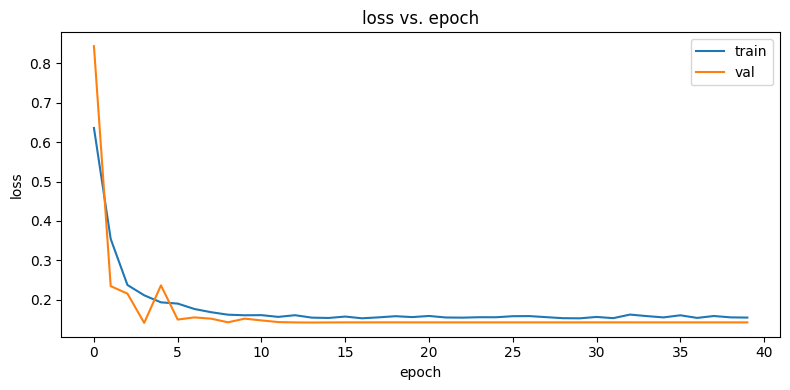

In [ ]:
import torch
torch.manual_seed(seed=42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

def train_epoch(model, dl, criterion, optimizer):
    model.train()
    losses = []
    for region, customer, x, y in dl:
        region, customer = region.to(device), customer.to(device)
        x, y = x.to(device), y.to(device)
        decoder_input = torch.cat(tensors=[x[:, -1:, :], y[:, :-1, :]], dim=1)

        tgt_mask = generate_square_subsequent_mask(sz=decoder_input.size(1)).to(device)
        preds = model(region=region, customer=customer, src_feats=x,
            tgt_feats=decoder_input, tgt_mask=tgt_mask)
        loss = criterion(input=preds, target=y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return float(np.mean(losses))

@torch.no_grad()
def eval_epoch(model, dl, criterion):
    model.eval()
    losses = []
    for region, customer, x, y in dl:
        region, customer = region.to(device), customer.to(device)
        x, y = x.to(device), y.to(device)
        decoder_input = torch.cat(tensors=[x[:, -1:, :], y[:, :-1, :]], dim=1)
        tgt_mask = generate_square_subsequent_mask(sz=decoder_input.size(1)).to(device)
        preds = model(region=region, customer=customer, src_feats=x,
            tgt_feats=decoder_input, tgt_mask=tgt_mask)
        loss = criterion(input=preds, target=y)
        losses.append(loss.item())
    return float(np.mean(losses))

def train_model(model, dl_train, dl_val, save_path, epochs=20):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
        mode='min', factor=0.1, patience=3)

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs+1):
        train_loss = train_epoch(model=model, dl=dl_train, criterion=criterion,
            optimizer=optimizer)
        history['train_loss'].append(train_loss)
        val_loss = eval_epoch(model=model, dl=dl_val, criterion=criterion)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(obj=model.state_dict(), f=save_path)

    return model, history

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_history, label='train', x='epoch', y='train_loss')
    sns.lineplot(data=df_history, label='val', x='epoch', y='val_loss')
    plt.legend(loc='best')
    plt.title(label=f'loss vs. epoch')
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss')
    plt.tight_layout()
    plt.show()

save_path = 'model.pth'
start_time = time.time()
model, history = train_model(model=model, dl_train=dl_train, dl_val=dl_test,
    save_path=save_path, epochs=40)
print(f"Training duration: %.2fs"%(time.time() - start_time))
plot_history(history=history)

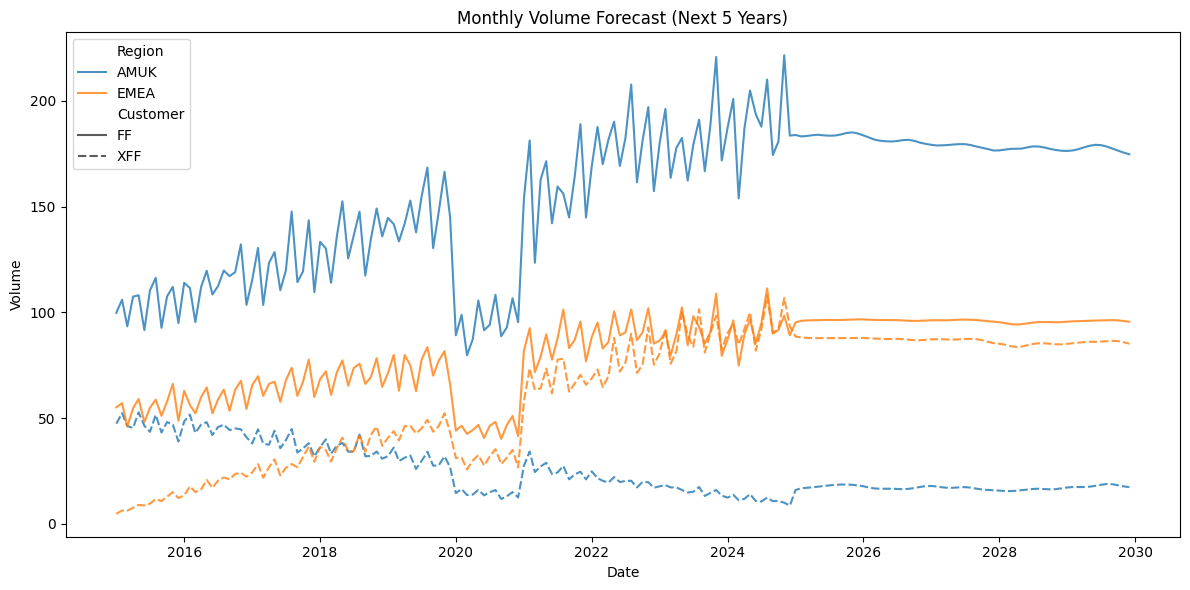

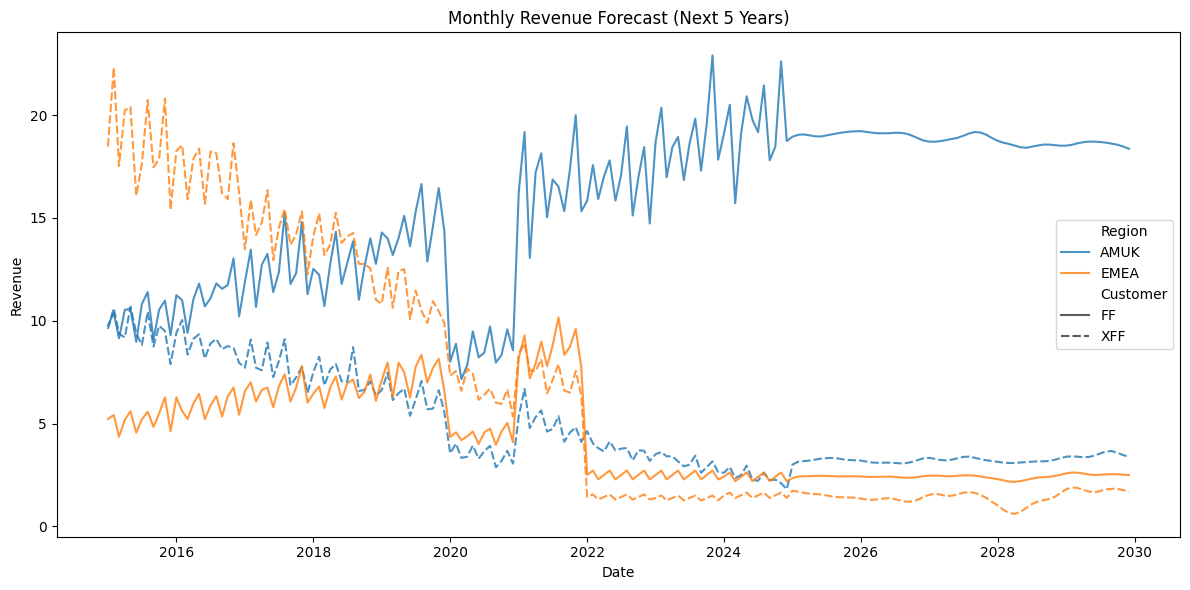

In [ ]:
import torch
torch.manual_seed(seed=42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model.load_state_dict(torch.load(f=save_path, weights_only=True))

in_window, out_window = 24, 12
forecast_horizon = 5 * 12

def forecast_entity(region_name, customer_name, df):
    model.eval()
    data = df[features].values.astype(np.float32)
    history = torch.tensor(data=data[-in_window:], dtype=torch.float32)\
        .unsqueeze(0).to(device)
    region = torch.tensor(data=[region2idx[region_name]],
        dtype=torch.long).to(device)
    customer = torch.tensor(data=[customer2idx[customer_name]],
            dtype=torch.long).to(device)

    full_preds = []
    with torch.no_grad():
        preds = model.predict(region=region, customer=customer,
            src_feats=history, pred_len=forecast_horizon)
    preds = preds.squeeze(0).cpu().numpy()
    preds_inv = scalers[(region_name, customer_name)].inverse_transform(X=preds)
    dates = pd.date_range(start=df['Date'].max() + pd.offsets.MonthBegin(),
        periods=forecast_horizon, freq='MS')
    df_pred = pd.DataFrame({
        'Date': dates,
        'Region': region_name,
        'Customer': customer_name,
        'Volume': preds_inv[:, 0],
        'Revenue': preds_inv[:, 1]
    })
    return df_pred

dfs_forecast = []
for r in sorted(region2idx.keys()):
    for c in sorted(customer2idx.keys()):
        df_entity = df_scaled[(df_scaled['Region']==r)
            &(df_scaled['Customer']==c)].sort_values(by='Date').copy()
        df_pred = forecast_entity(region_name=r, customer_name=c, df=df_entity)
        dfs_forecast.append(df_pred)

df_forecast = pd.concat(dfs_forecast, ignore_index=True)
df_forecast = pd.concat([df_history.assign(Source='Actual'),
    df_forecast.assign(Source='Forecast')])

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_forecast, x='Date', y='Volume', hue='Region', style='Customer',
    alpha=0.8)
plt.title('Monthly Volume Forecast (Next 5 Years)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_forecast, x='Date', y='Revenue', hue='Region', style='Customer',
    alpha=0.8)
plt.title('Monthly Revenue Forecast (Next 5 Years)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(loc='best')
plt.tight_layout()
plt.show()